In [2]:
# Loading packages

# Path and file, data handling
import os
import h5py
import numpy as np
import pandas as pd
from pathlib import Path

# Image preprocessing
from skimage.io import imread
import cv2

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
# from sklearn.metrics import plot_confusion_matrix

# Splitting dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Image Augmentation
import imgaug as aug
import imgaug.augmenters as iaa

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [7]:
data_dir = Path('D:/Projects/Covid19/data/')

train_dir = data_dir / 'Original_cropped'

train_dir

WindowsPath('D:/Projects/Covid19/data/Original_cropped')

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    validation_split=0.2) # set validation split
    
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    color_mode="rgb",
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=4,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1292 images belonging to 3 classes.
Found 322 images belonging to 3 classes.


In [50]:
train_generator.

<generator object Iterator._flow_index at 0x00000251BF5A3990>

In [4]:
epochs=50
based_model_last_block_layer_number = 15
train_steps = train_generator.samples//train_generator.batch_size
val_steps = validation_generator.samples//validation_generator.batch_size

In [5]:
# VGG16

base_model = VGG16(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

multi_class_disease = base_model.output
multi_class_disease = GlobalAveragePooling2D()(multi_class_disease)
# multi_class_disease = Dense(1024, activation='relu')(multi_class_disease)
# multi_class_disease = Dense(512,activation='relu')(multi_class_disease)
multi_class_disease = Dense(3, activation='softmax')(multi_class_disease)

multi_class_disease = Model(base_model.input, multi_class_disease)
multi_class_disease.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
multi_class_disease.compile(optimizer=Adam(learning_rate=1e-4, epsilon=1e-05),
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])


In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
top_weights_path = os.path.join(os.path.abspath("D:/Projects/Covid19/Model/VGG16/"), 'VGG16_pretrained.h5')

callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)
]

In [9]:
# training model

history = multi_class_disease.fit_generator(train_generator,
                                            steps_per_epoch=train_steps,
                                            epochs=epochs,
                                            validation_data=validation_generator,
                                            validation_steps=val_steps,
                                            callbacks=callbacks_list)

Epoch 1/50
322/323 [============================>.] - ETA: 0s - loss: 1.1299 - accuracy: 0.3944
Epoch 00001: val_accuracy improved from -inf to 0.31563, saving model to D:\Projects\Covid19\Model\VGG16\VGG16_pretrained.h5
323/323 [==============================] - 196s 606ms/step - loss: 1.1298 - accuracy: 0.3932 - val_loss: 1.0936 - val_accuracy: 0.3156
Epoch 2/50
322/323 [============================>.] - ETA: 0s - loss: 1.0718 - accuracy: 0.3292
Epoch 00002: val_accuracy improved from 0.31563 to 0.33750, saving model to D:\Projects\Covid19\Model\VGG16\VGG16_pretrained.h5
323/323 [==============================] - 93s 289ms/step - loss: 1.0719 - accuracy: 0.3289 - val_loss: 1.0483 - val_accuracy: 0.3375
Epoch 3/50
322/323 [============================>.] - ETA: 0s - loss: 1.0493 - accuracy: 0.4262
Epoch 00003: val_accuracy improved from 0.33750 to 0.38125, saving model to D:\Projects\Covid19\Model\VGG16\VGG16_pretrained.h5
323/323 [==============================] - 92s 285ms/step - lo

In [10]:
print("\nStarting to Fine Tune Model\n")


Starting to Fine Tune Model



In [11]:
multi_class_disease.load_weights(top_weights_path)

In [12]:
# Compiling with Adam optimizer

multi_class_disease.compile(optimizer=Adam(learning_rate=1e-4, epsilon=1e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
for layer in multi_class_disease.layers[:based_model_last_block_layer_number]:
    layer.trainable = False
for layer in multi_class_disease.layers[based_model_last_block_layer_number:]:
    layer.trainable = True

In [14]:
# save weights of best training epoch: monitor either val_loss or val_acc

final_weights_path = os.path.join(os.path.abspath("D:/Projects/Covid19/Model/VGG16/"), 'VGG16_final_weights.h5')

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)
]

In [15]:
history2 = multi_class_disease.fit_generator(train_generator,
                                            steps_per_epoch=train_steps,
                                            epochs=epochs,
                                            validation_data=validation_generator,
                                            validation_steps=val_steps,
                                            callbacks=callbacks_list)

Epoch 1/50
322/323 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9744
Epoch 00001: val_accuracy improved from -inf to 0.83750, saving model to D:\Projects\Covid19\Model\VGG16\VGG16_final_weights.h5
323/323 [==============================] - 91s 280ms/step - loss: 0.0790 - accuracy: 0.9745 - val_loss: 0.5856 - val_accuracy: 0.8375
Epoch 2/50
322/323 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9705
Epoch 00002: val_accuracy improved from 0.83750 to 0.84062, saving model to D:\Projects\Covid19\Model\VGG16\VGG16_final_weights.h5
323/323 [==============================] - 91s 282ms/step - loss: 0.0773 - accuracy: 0.9706 - val_loss: 0.6016 - val_accuracy: 0.8406
Epoch 3/50
322/323 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9713
Epoch 00003: val_accuracy did not improve from 0.84062
323/323 [==============================] - 90s 279ms/step - loss: 0.0760 - accuracy: 0.9714 - val_loss: 0.6107 - val_accuracy: 0.8

In [16]:
model_json = multi_class_disease.to_json()

with open(os.path.join('D:/Projects/Covid19/Model/VGG16/', 'VGG16_model.json'), 'w') as json_file:
    json_file.write(model_json)

In [9]:
model = load_model("D:/Projects/Covid19/Model/VGG16/VGG16_final_weights.h5")

In [40]:
validation_generator.reset()

In [41]:
predicted_vals = model.predict_generator(validation_generator, steps = len(validation_generator))

In [42]:
y_pred = np.argmax(predicted_vals, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[49 42 27]
 [39 45 31]
 [30 39 20]]


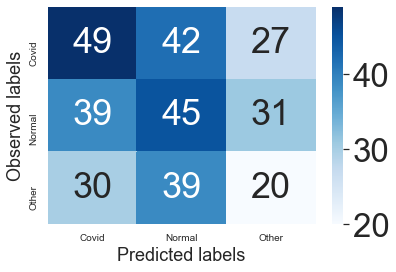

In [43]:
cm  = confusion_matrix(validation_generator.classes, y_pred)
ax = plt.subplot()
sns.set(font_scale=3.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g")

label_font = {'size' : 18}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('Observed labels', fontdict=label_font)

title_font = {'size': 18}
ax.set_xlabel('Predicted labels', fontdict=label_font)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Other'])
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Other'])
plt.show()

<Figure size 432x288 with 0 Axes>

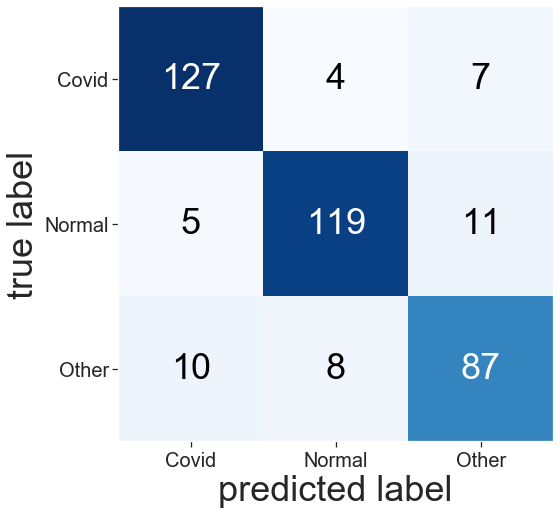

In [53]:
# cm  = confusion_matrix(validation_generator.classes, y_pred)
cm = np.array([[127, 4, 7],
                       [5, 119, 11],
                       [10, 8, 87]])
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g")

plt.xticks(range(3), ['Covid', 'Normal', 'Other'], fontsize=20)
plt.yticks(range(3), ['Covid', 'Normal', 'Other'], fontsize=20)
plt.savefig('vgg_confusion.png')
plt.show()

In [45]:
print('Classification Report')
target_names = ['Covid', 'Normal', 'Other']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Covid       0.42      0.42      0.42       118
      Normal       0.36      0.39      0.37       115
       Other       0.26      0.22      0.24        89

    accuracy                           0.35       322
   macro avg       0.34      0.34      0.34       322
weighted avg       0.35      0.35      0.35       322



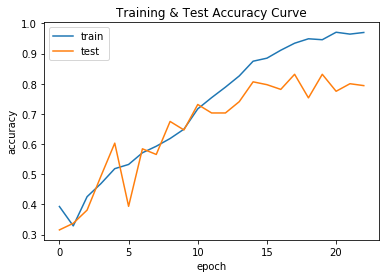

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Test Accuracy Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

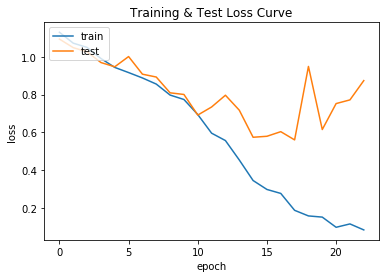

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Test Loss Curve")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

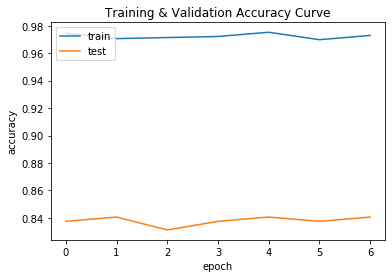

In [40]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training & Validation Accuracy Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

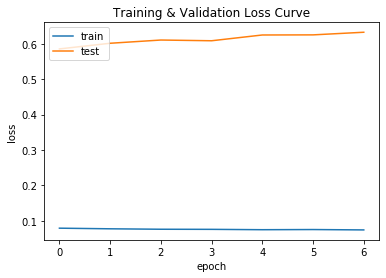

In [41]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("Training & Validation Loss Curve")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

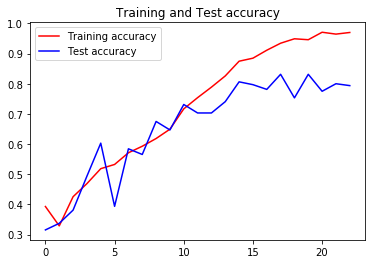

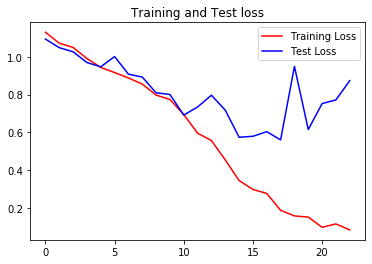

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('train_test_acc_vgg.png', dpi=100)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Test Loss')
plt.title('Training and Test loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('train_test_loss_vgg.png', dpi=100)
plt.show()